# UnSupervisedIOHMM

In [1]:
from __future__ import  division

import json
import warnings

import numpy as np
import pandas as pd

from IOHMM import UnSupervisedIOHMM
from IOHMM import OLS, DiscreteMNL, CrossEntropyMNL

warnings.simplefilter("ignore")

## Load data

In [2]:
data = pd.read_csv("data/goldstock_prepared.csv")
data.head()
data = data.dropna()

input_data = data[['Open', 'High', 'Low', 'Close', 'Volume']][:-1]


# close price of the next day
output_data = data['Close'][1:]
# to start from 0 index
output_data.index = range(len(output_data))

output_data.name = 'Close-next-day'

data = pd.concat([input_data, output_data], axis=1)

data.head()
print(len(data))

2510


# Example 1

## Set up a simple model manully

In [3]:
# set two hidden states
SHMM = UnSupervisedIOHMM(num_states=3, max_EM_iter=200, EM_tol=1e-6)

# This model has only one output which is modeled by a linear regression model
SHMM.set_models(model_emissions = [OLS()], 
                model_transition=CrossEntropyMNL(solver='lbfgs'),
                model_initial=CrossEntropyMNL(solver='lbfgs'))

# We don't set any covariates to this OLS model
SHMM.set_inputs(covariates_initial = ['Open', 'High', 'Low', 'Close', 'Volume'], covariates_transition = ['Open', 'High', 'Low', 'Close', 'Volume'], covariates_emissions = [['Open', 'High', 'Low', 'Close', 'Volume'],['Open', 'High', 'Low', 'Close', 'Volume'],['Open', 'High', 'Low', 'Close', 'Volume']])

SHMM.set_outputs([['Close-next-day']])

# we only have a list of one sequence.
SHMM.set_data([data])

## Start training

In [4]:
SHMM.train()

## See the training results

In [6]:
print(SHMM.model_initial)
print(SHMM.model_transition)
print(SHMM.model_emissions)

[<IOHMM.linear_models.CrossEntropyMNL object at 0x7fbda1e1c700>, <IOHMM.linear_models.CrossEntropyMNL object at 0x7fbda1e1c9a0>, <IOHMM.linear_models.CrossEntropyMNL object at 0x7fbda1e1caf0>]
[[<IOHMM.linear_models.OLS object at 0x7fbda1e1ca90>], [<IOHMM.linear_models.OLS object at 0x7fbda1e1da20>], [<IOHMM.linear_models.OLS object at 0x7fbda1e1db10>]]


In [7]:
print("Initial state distribution")
print(SHMM.model_initial.coef)

print("Transition matrix")
print(SHMM.model_transition[0].coef)
print(SHMM.model_transition[1].coef)
print(SHMM.model_transition[2].coef)

print("Emission model")
print(SHMM.model_emissions[0][0].coef)
print(SHMM.model_emissions[1][0].coef)
print(SHMM.model_emissions[2][0].coef)

Initial state distribution
[[-1.00571315e-08 -2.03898285e-05 -2.05356569e-05 -2.03375314e-05
  -2.04089370e-05 -1.67026829e-03]
 [-1.00571315e-08 -2.03898285e-05 -2.05356569e-05 -2.03375314e-05
  -2.04089370e-05 -1.67026829e-03]
 [ 2.01142631e-08  4.07796569e-05  4.10713137e-05  4.06750628e-05
   4.08178740e-05  3.34053658e-03]]
Transition matrix
[[ 3.74933919e-08  1.02889203e-04  1.05662672e-04  1.01159278e-04
   1.03709772e-04 -1.56565470e-07]
 [-8.04731288e-08 -1.50239918e-04 -1.51915973e-04 -1.49161119e-04
  -1.50798602e-04  1.82148876e-07]
 [ 4.29797369e-08  4.73507148e-05  4.62533004e-05  4.80018412e-05
   4.70888299e-05 -2.55834058e-08]]
[[-7.16617077e-07 -1.01106128e-03 -1.01418073e-03 -1.00781526e-03
  -1.01190641e-03  1.42238807e-05]
 [ 4.30039387e-07  5.25202122e-04  5.26613481e-04  5.24948189e-04
   5.26934275e-04 -6.23735944e-06]
 [ 2.86577690e-07  4.85859158e-04  4.87567254e-04  4.82867069e-04
   4.84972133e-04 -7.98652123e-06]]
[[-1.30475695e-08  1.07228554e-05  1.195688

In [8]:
# The scale/dispersion of the OLS model for each hidden states
print(np.sqrt(SHMM.model_emissions[0][0].dispersion))
print(np.sqrt(SHMM.model_emissions[1][0].dispersion))
print(np.sqrt(SHMM.model_emissions[2][0].dispersion))

[[12.86256298]]
[[1.18684451]]
[[3.37281347]]


In [5]:
viterbi_path = SHMM.viterbi()
print(viterbi_path)

[2 2 2 ... 2 2 2]


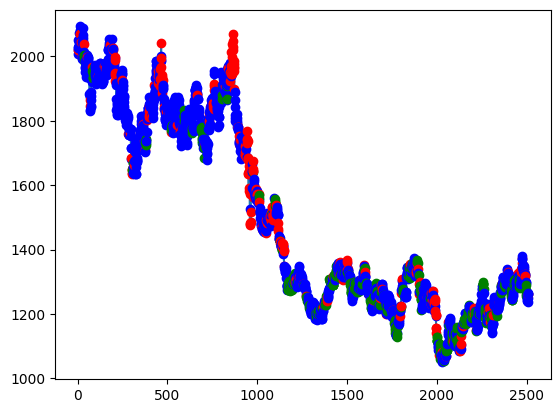

In [9]:
# plot the output data and the hidden states, i want that the line of the close data becomes red when state is 0, grey when state is 1 and blue when state is 2
import matplotlib.pyplot as plt
plt.plot(data['Close-next-day'])
for i in range(len(viterbi_path)):
    if viterbi_path[i] == 0:
        plt.plot(i, data['Close-next-day'][i], 'ro')
    elif viterbi_path[i] == 1:
        plt.plot(i, data['Close-next-day'][i], 'go')
    else:
        plt.plot(i, data['Close-next-day'][i], 'bo')
plt.show()

In [13]:
import hmmlearn.hmm as hmm

model = hmm.GaussianHMM(n_components=3, covariance_type="full", n_iter=1000)
model.fit(data[['Close-next-day']])
hidden_states = model.predict(data[['Close-next-day']])
print(hidden_states)

[1 2 1 ... 0 0 0]


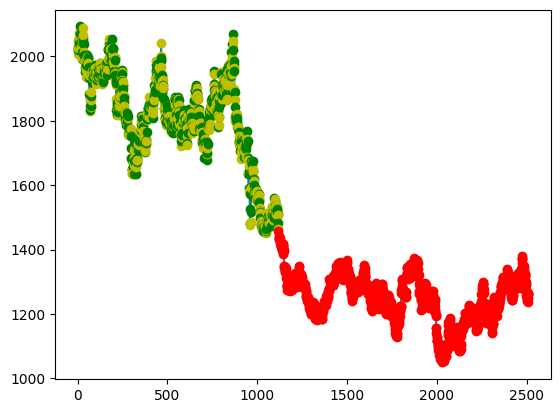

In [14]:
# plot the output data and the hidden states, i want that the line of the close data becomes red when state is 0, grey when state is 1 and blue when state is 2
import matplotlib.pyplot as plt
plt.plot(data['Close-next-day'])
for i in range(len(hidden_states)):
    if hidden_states[i] == 0:
        plt.plot(i, data['Close-next-day'][i], 'ro')
    elif hidden_states[i] == 1:
        plt.plot(i, data['Close-next-day'][i], 'go')
    elif hidden_states[i] == 2:
        plt.plot(i, data['Close-next-day'][i], 'yo')
    else:
        plt.plot(i, data['Close-next-day'][i], 'bo')
plt.show()